<a href="https://colab.research.google.com/github/Lidivinekeng/Project-02/blob/main/project_02_insurance_Lidivine_Kengne_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# prediction Adult income


- prediction Adult income: explore the possibility in predicting income level based on the individual’s personal information




*   Author : Lidivine Kengne



### **Import Libraries**

In [56]:
# Pandas
import pandas as pd
# Numpy
import numpy as np
# MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


## Classification Metrics
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay,
                             PrecisionRecallDisplay, RocCurveDisplay,
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)



# Set global scikit-learn configuration
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

## Filter ALL warnings
import warnings
warnings.filterwarnings('ignore')

#### Evaluation Functions

In [57]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                         output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                         label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                        output_dict=True,figsize=figsize,
                                        colorbar=colorbar, cmap=cmap_test,
                                        label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

### **Load the Data insurance**

1. Source of data

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
df_insurance = "/content/drive/MyDrive/StudentFolders16wk20wk/CodingDojo/project/Car_Insurance_Claim.csv"
df = pd.read_csv(df_insurance)

###.head()

2. Brief description of data

In [60]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

3. What is the target?
- outcome

4. What does one row represent? (A person? A business? An event? A product?)
- person

5. Is this a classification or regression problem?
- classification

6. How many features does the data have?
- 18

7. How many rows are in the dataset?
- 10000

8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?
- modeling

## **Clean the Data**

#### **Duplicates**

In [62]:
## Display the state of whether a row is duplicated or not
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [63]:
## Display the sum of duplicate rows in the dataset
df.duplicated().sum()

0

In [64]:
## Confirm duplicate rows have been dropped
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### **Inspect Column Datatypes for Errors**

In [65]:
## Display column names and datatypes
df.dtypes

ID                       int64
AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object

In [66]:
## Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

### **Inspect Column Names for Errors**


In [67]:
## Display column names
df.columns

Index(['ID', 'AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION',
       'INCOME', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR',
       'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'VEHICLE_TYPE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')

In [68]:
# Use .nunqiue() to get # of unique values for each column and save as a variable.
df.nunique() / len(df)*100

ID                     100.00
AGE                      0.04
GENDER                   0.02
RACE                     0.02
DRIVING_EXPERIENCE       0.04
EDUCATION                0.03
INCOME                   0.04
CREDIT_SCORE            90.18
VEHICLE_OWNERSHIP        0.02
VEHICLE_YEAR             0.02
MARRIED                  0.02
CHILDREN                 0.02
POSTAL_CODE              0.04
ANNUAL_MILEAGE           0.21
VEHICLE_TYPE             0.02
SPEEDING_VIOLATIONS      0.21
DUIS                     0.07
PAST_ACCIDENTS           0.15
OUTCOME                  0.02
dtype: float64

###drop the columns that are not in the dictionary

- the id is 100% unique and this data is a random number with no impact to de outcome so we can drop

In [69]:
# Drop the string column from the DataFrame.
df.drop(['ID'],axis=1, inplace= True)

In [70]:
df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


### **Inspect Values for Errors**

#### **Numeric Columns**

In [71]:
## Display the descriptive statistics for the non-numeric columns
df.describe(include="number")

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


##### **'Postal_code' column**

In [72]:
# Display the unique values from the column
print(df['POSTAL_CODE'].unique())

[10238 32765 92101 21217]


the postale code look like numerical  but it is a categorical column . let change to categorical  

In [73]:
# Change the datatype  column to object
df['POSTAL_CODE'] = df['POSTAL_CODE'].astype(object)
# Confirm the datatype
df['POSTAL_CODE'].dtype

dtype('O')

#### **Categorical Columns**

In [74]:
# Define a variable that contains the names of the object datatype columns
object_cols = df.select_dtypes('object').columns

In [75]:
## Display the object datatype columns
object_cols

Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'POSTAL_CODE', 'VEHICLE_TYPE'],
      dtype='object')

In [76]:
## Loop through the index of object_data_types
for column in object_cols:
    # Display the unique values from the column
    print(column)
    print(df[column].unique())
    print('\n')

AGE
['65+' '16-25' '26-39' '40-64']


GENDER
['female' 'male']


RACE
['majority' 'minority']


DRIVING_EXPERIENCE
['0-9y' '10-19y' '20-29y' '30y+']


EDUCATION
['high school' 'none' 'university']


INCOME
['upper class' 'poverty' 'working class' 'middle class']


VEHICLE_YEAR
['after 2015' 'before 2015']


POSTAL_CODE
[10238 32765 92101 21217]


VEHICLE_TYPE
['sedan' 'sports car']




##### **'VEHICLE_YEAR' column**

In [77]:
# Display the unique values from the column
print(df['VEHICLE_YEAR'].unique())

['after 2015' 'before 2015']


In [87]:
# Replace boolean values with 0s and 1s
df['VEHICLE_YEAR'].replace({'before 2015':0, 'after 2015':1}, inplace=True)

# Rename 'vehicule_year' to 'isafter2015' for clarity
df.rename(columns={'VEHICLE_YEAR':'isafter2015'}, inplace=True)
df[['isafter2015']].value_counts()


isafter2015
0              6967
1              3033
dtype: int64

##### **'VEHICLE_TYPE' column**

In [88]:
# Display the unique values from the column
print(df['VEHICLE_TYPE'].unique())

['sedan' 'sports car']


In [89]:
# Replace boolean values with 0s and 1s
df['VEHICLE_TYPE'].replace({'sports car':0, 'sedan':1}, inplace=True)

# Rename 'vehicule_type' to 'issedan' for clarity
df.rename(columns={'VEHICLE_TYPE':'issedan'}, inplace=True)
df[['issedan']].value_counts()


issedan
1          9523
0           477
dtype: int64

##### **'RACE' column**

In [90]:
# Display the unique values from the column
print(df['RACE'].unique())

['majority' 'minority']


In [91]:
# Replace boolean values with 0s and 1s
df['RACE'].replace({'minority':0, 'majority':1}, inplace=True)

# Rename 'RACE' to 'isMajority' for clarity
df.rename(columns={'RACE':'ismajority'}, inplace=True)
df[['ismajority']].value_counts()


ismajority
1             9012
0              988
dtype: int64

##### **'GENDER' column**

In [94]:
# Display the value counts from the column
df['GENDER'].value_counts()

F    5010
M    4990
Name: GENDER, dtype: int64

In [96]:
# Replace boolean values with 0s and 1s
df['GENDER'].replace({'M':0, 'F':1}, inplace=True)

# Rename 'Gender' to 'isfemale' for clarity
df.rename(columns={'GENDER':'isfemale'}, inplace=True)

df[['isfemale']].value_counts()

isfemale
1           5010
0           4990
dtype: int64

## Missing Values

In [97]:
# Get the number of null values for all columns and save as a variable
df.isna().sum()

AGE                      0
isfemale                 0
ismajority               0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
isafter2015              0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
issedan                  0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [98]:
# Use this result to calculate the percentage of null values for each column.
df.isna().sum() / len(df) *100

AGE                    0.00
isfemale               0.00
ismajority             0.00
DRIVING_EXPERIENCE     0.00
EDUCATION              0.00
INCOME                 0.00
CREDIT_SCORE           9.82
VEHICLE_OWNERSHIP      0.00
isafter2015            0.00
MARRIED                0.00
CHILDREN               0.00
POSTAL_CODE            0.00
ANNUAL_MILEAGE         9.57
issedan                0.00
SPEEDING_VIOLATIONS    0.00
DUIS                   0.00
PAST_ACCIDENTS         0.00
OUTCOME                0.00
dtype: float64

## Consistent Values

In [99]:
# make the list of string columns (after dropping previous cols)
string_cols = df.select_dtypes("number").columns
string_cols
# loop through the list of string columns
for col in string_cols:
  # print the value counts for the column
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  # Print an empty line for readability
  print('\n')

Value Counts for isfemale
1    5010
0    4990
Name: isfemale, dtype: int64


Value Counts for ismajority
1    9012
0     988
Name: ismajority, dtype: int64


Value Counts for CREDIT_SCORE
0.629027    1
0.618094    1
0.396540    1
0.578306    1
0.633275    1
           ..
0.309272    1
0.847325    1
0.432080    1
0.527041    1
0.435225    1
Name: CREDIT_SCORE, Length: 9018, dtype: int64


Value Counts for VEHICLE_OWNERSHIP
1.0    6970
0.0    3030
Name: VEHICLE_OWNERSHIP, dtype: int64


Value Counts for isafter2015
0    6967
1    3033
Name: isafter2015, dtype: int64


Value Counts for MARRIED
0.0    5018
1.0    4982
Name: MARRIED, dtype: int64


Value Counts for CHILDREN
1.0    6888
0.0    3112
Name: CHILDREN, dtype: int64


Value Counts for POSTAL_CODE
10238    6940
32765    2456
92101     484
21217     120
Name: POSTAL_CODE, dtype: int64


Value Counts for ANNUAL_MILEAGE
11000.0    1253
12000.0    1218
13000.0    1137
10000.0    1071
14000.0     894
9000.0      856
15000.0     632
8000

##exploratory data analysis

##### **Univariate Functions**


- Define your target column:
  - OUTCOME


In [ ]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [131]:
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


#### Histograms to view the distributions of numerical features in your dataset

In [102]:
#define numerical
num_cols = df.select_dtypes('number').columns
num_cols

Index(['isfemale', 'ismajority', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
       'isafter2015', 'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE',
       'issedan', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')

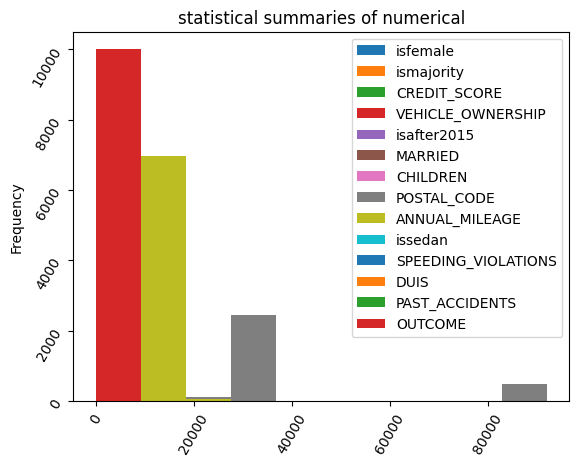

In [104]:
# Histograms to view the distributions of numerical features in your dataset
ax = df[num_cols].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('statistical summaries of numerical');

#### Histograms to each of numerical features in your dataset

**'isfemale'**

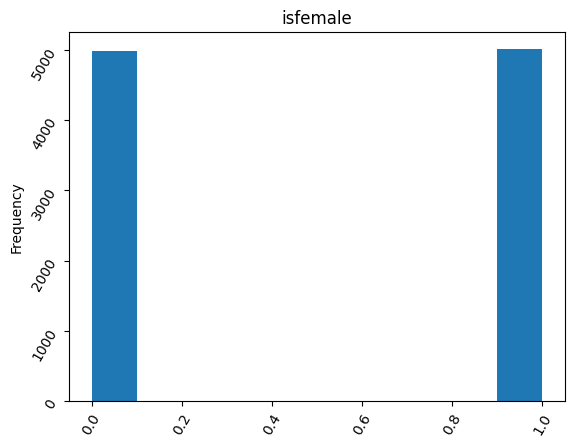

In [119]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['isfemale'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('isfemale');

**'ismajority'**

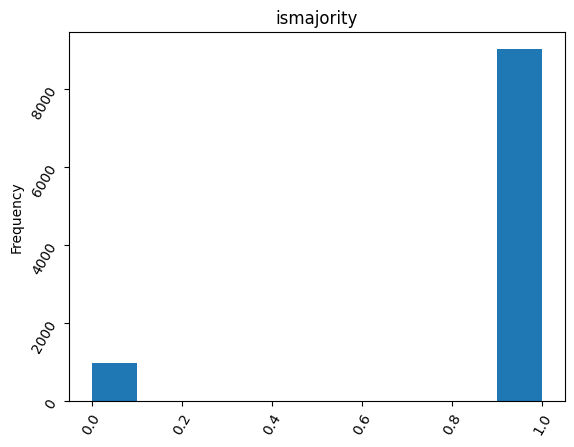

In [120]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['ismajority'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('ismajority');

**'CREDIT_SCORE'**

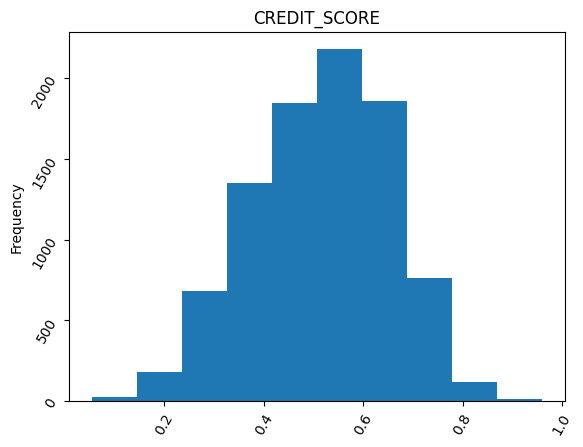

In [121]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['CREDIT_SCORE'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('CREDIT_SCORE');

**'VEHICLE_OWNERSHIP'**

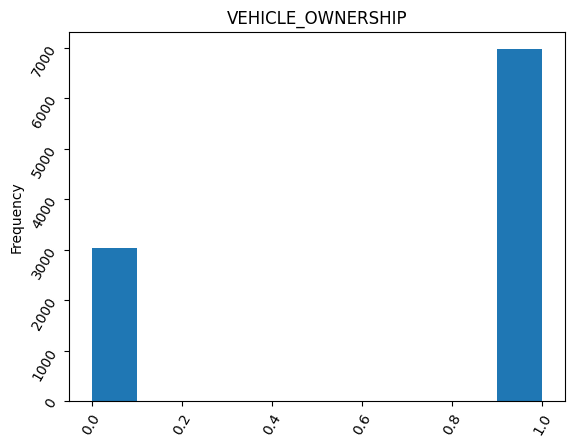

In [122]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['VEHICLE_OWNERSHIP'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('VEHICLE_OWNERSHIP');

**'isafter2015'**

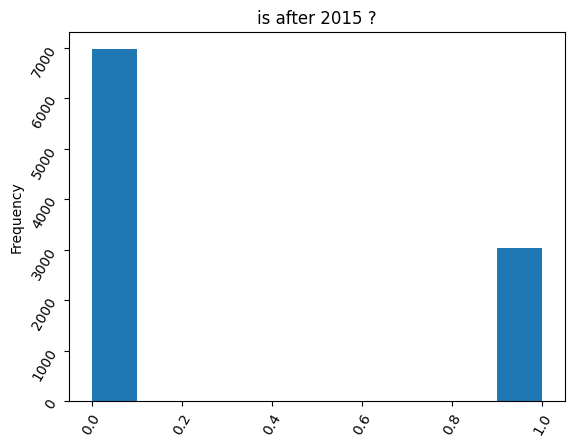

In [123]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['isafter2015'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('is after 2015 ?');

**'MARRIED'**

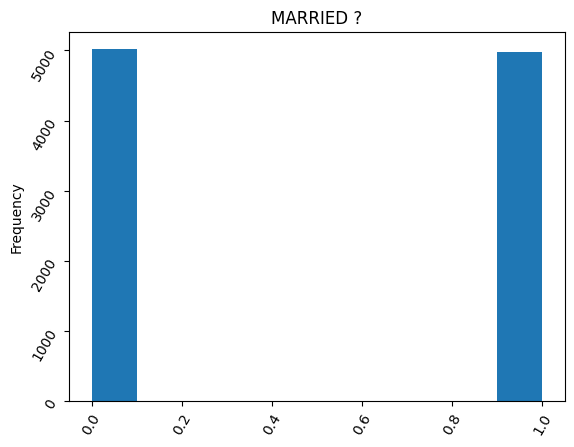

In [124]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['MARRIED'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('MARRIED ?');

**'CHILDREN'**

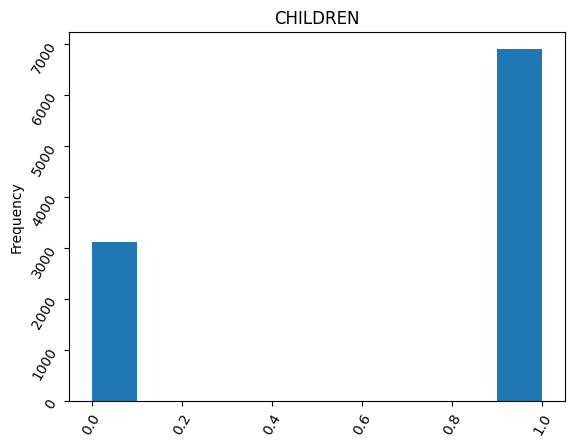

In [118]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['CHILDREN'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('CHILDREN');

**'POSTAL_CODE'**

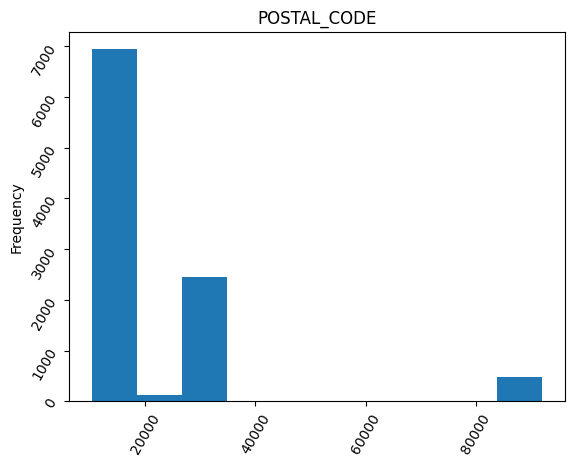

In [117]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['POSTAL_CODE'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('POSTAL_CODE');

**'ANNUAL_MILEAGE'**

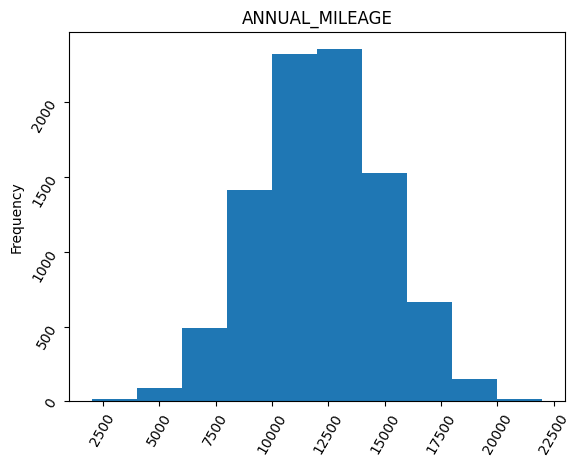

In [116]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['ANNUAL_MILEAGE'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('ANNUAL_MILEAGE');

**'issedan'**

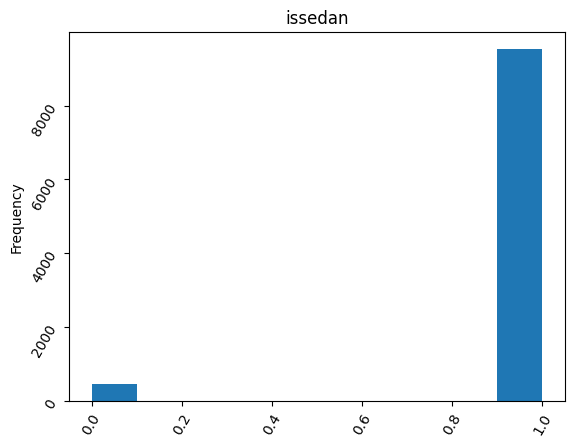

In [115]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['issedan'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('issedan');

**'SPEEDING_VIOLATIONS'**

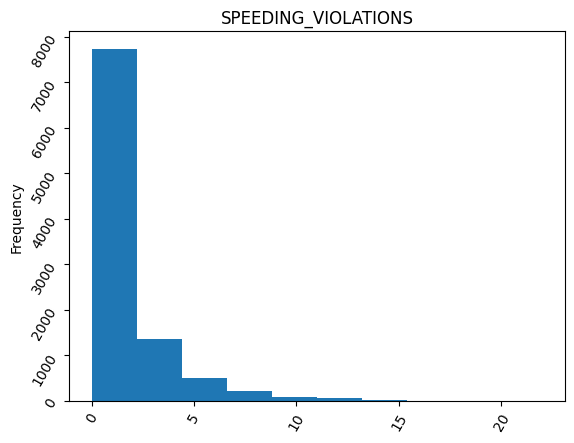

In [114]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['SPEEDING_VIOLATIONS'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('SPEEDING_VIOLATIONS');

**'DUIS'**

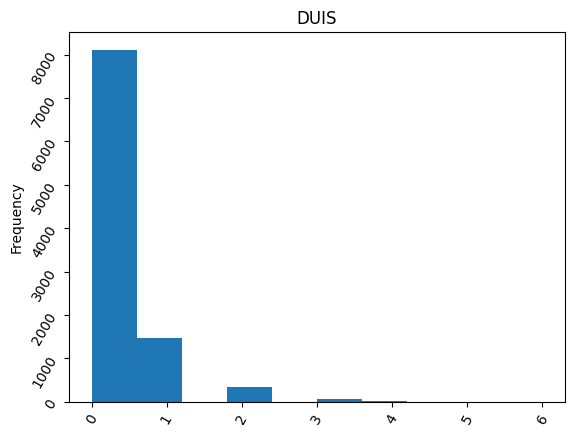

In [113]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['DUIS'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('DUIS');

**'PAST_ACCIDENTS'**

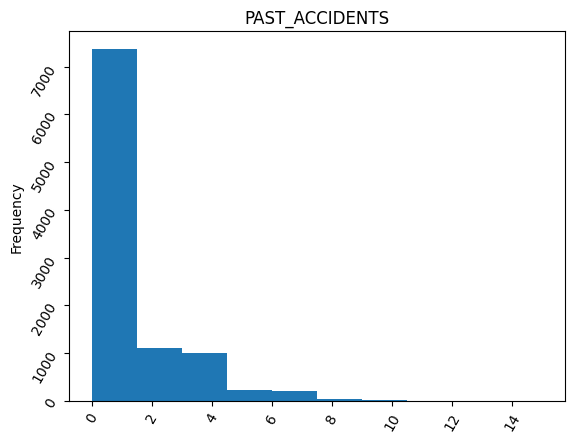

In [112]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['PAST_ACCIDENTS'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('PAST_ACCIDENTS');

**'OUTCOME'**

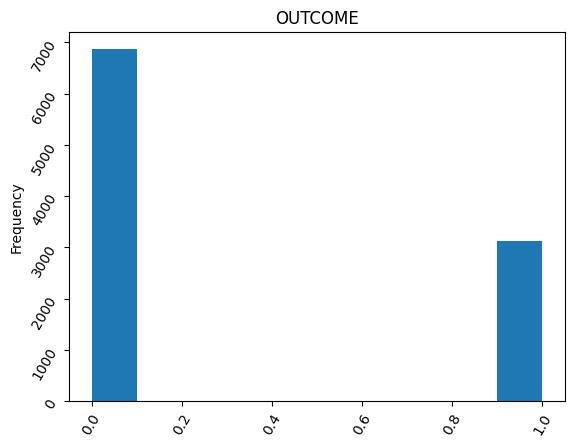

In [111]:
# Histograms to view the distributions of numerical features in your dataset
ax = df['OUTCOME'].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('OUTCOME');

###### **Explore Univariate Categorical Function**

###Countplots to view the frequency of each class of categorial features in your dataset.

In [106]:
#define categorical
ca_cols = df.select_dtypes('object').columns
ca_cols

Index(['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME'], dtype='object')

**Countplots to view 'AGE'**

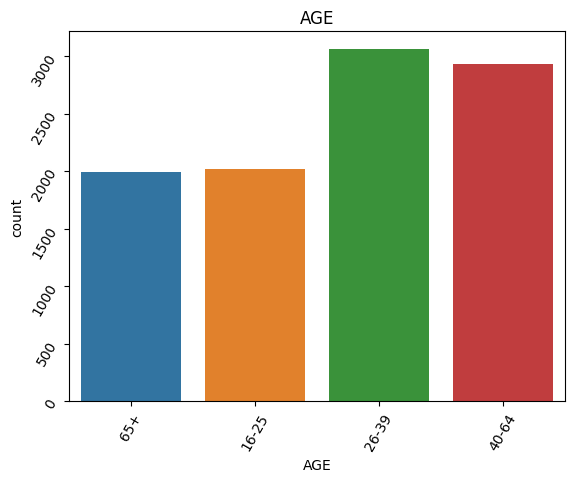

In [107]:
#Countplots to view 'AGE'
ax = sns.countplot(x = 'AGE' ,data = df)
## Rotate the tick values
ax.tick_params(rotation = 60)
## Set the Title
ax.set_title('AGE');

**Countplots to view for 'DRIVING_EXPERIENCE'**

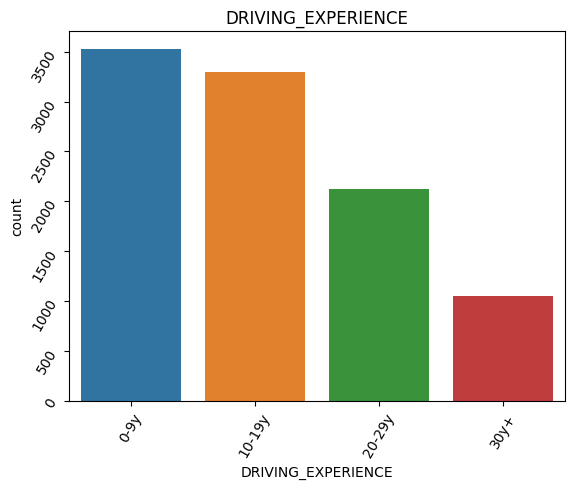

In [108]:
#Countplots to view for 'DRIVING_EXPERIENCE'
ax = sns.countplot(x = 'DRIVING_EXPERIENCE' ,data = df)
## Rotate the tick values
ax.tick_params(rotation = 60)
## Set the Title
ax.set_title('DRIVING_EXPERIENCE');

**Countplots to view for 'EDUCATION'**

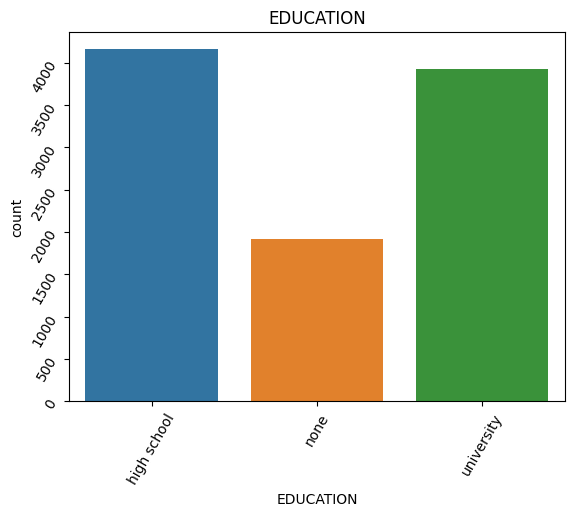

In [110]:
#Countplots to view for 'EDUCATION'
ax = sns.countplot(x = 'EDUCATION' ,data = df)
## Rotate the tick values
ax.tick_params(rotation = 60)
## Set the Title
ax.set_title('EDUCATION');

**Countplots to view for 'INCOME'**

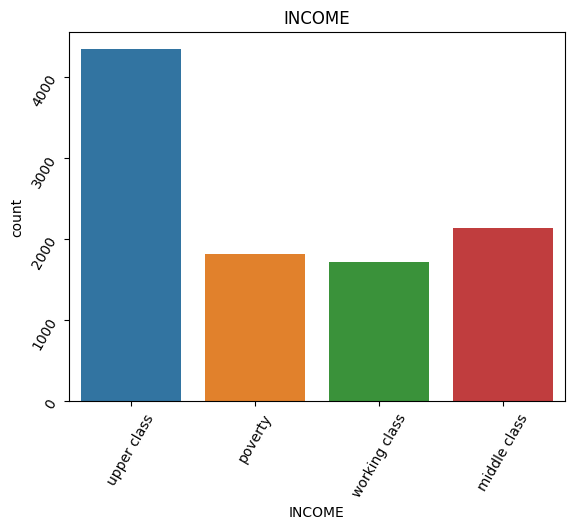

In [109]:
#Countplots to view for 'INCOME'
ax = sns.countplot(x = 'INCOME', data = df)
## Rotate the tick values
ax.tick_params(rotation = 60)
## Set the Title
ax.set_title('INCOME');

**correlation**

In [125]:
# Heatmap to view the correlation between features.
# Find correlations
corr = df.corr()
# tabular view of correlation values
corr

,isfemale,ismajority,CREDIT_SCORE,VEHICLE_OWNERSHIP,isafter2015,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,issedan,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
isfemale,1.000000,-0.006711,0.081587,-0.007385,-0.010674,-0.008393,0.002640,0.001996,0.015845,-0.000022,-0.202095,-0.094202,-0.223202,-0.107208
ismajority,-0.006711,1.000000,0.039359,0.034738,0.020895,0.021597,-0.007575,-0.004655,0.001983,0.006089,0.014068,0.015296,0.008848,-0.008280
CREDIT_SCORE,0.081587,0.039359,1.000000,0.312037,0.267560,0.281238,0.220658,0.009040,-0.174453,0.013871,0.204542,0.127366,0.180978,-0.325286
VEHICLE_OWNERSHIP,-0.007385,0.034738,0.312037,1.000000,0.158579,0.175626,0.125990,-0.004866,-0.097433,-0.005647,0.133868,0.086567,0.119521,-0.378921
isafter2015,-0.010674,0.020895,0.267560,0.158579,1.000000,0.129638,0.105189,0.006958,-0.077363,0.025185,0.102700,0.049981,0.097587,-0.294178
MARRIED,-0.008393,0.021597,0.281238,0.175626,0.129638,1.000000,0.287009,0.012045,-0.462193,-0.006905,0.218855,0.120840,0.215269,-0.262104
CHILDREN,0.002640,-0.007575,0.220658,0.125990,0.105189,0.287009,1.000000,0.020911,-0.447655,0.008672,0.220415,0.115354,0.206295,-0.232835
POSTAL_CODE,0.001996,-0.004655,0.009040,-0.004866,0.006958,0.012045,0.020911,1.000000,-0.133978,0.006169,0.113686,0.038492,-0.116985,0.095889
ANNUAL_MILEAGE,0.015845,0.001983,-0.174453,-0.097433,-0.077363,-0.462193,-0.447655,-0.133978,1.000000,0.010488,-0.323547,-0.116598,-0.195217,0.187154
issedan,-0.000022,0.006089,0.013871,-0.005647,0.025185,-0.006905,0.008672,0.006169,0.010488,1.000000,-0.001812,0.005156,0.013305,-0.005620


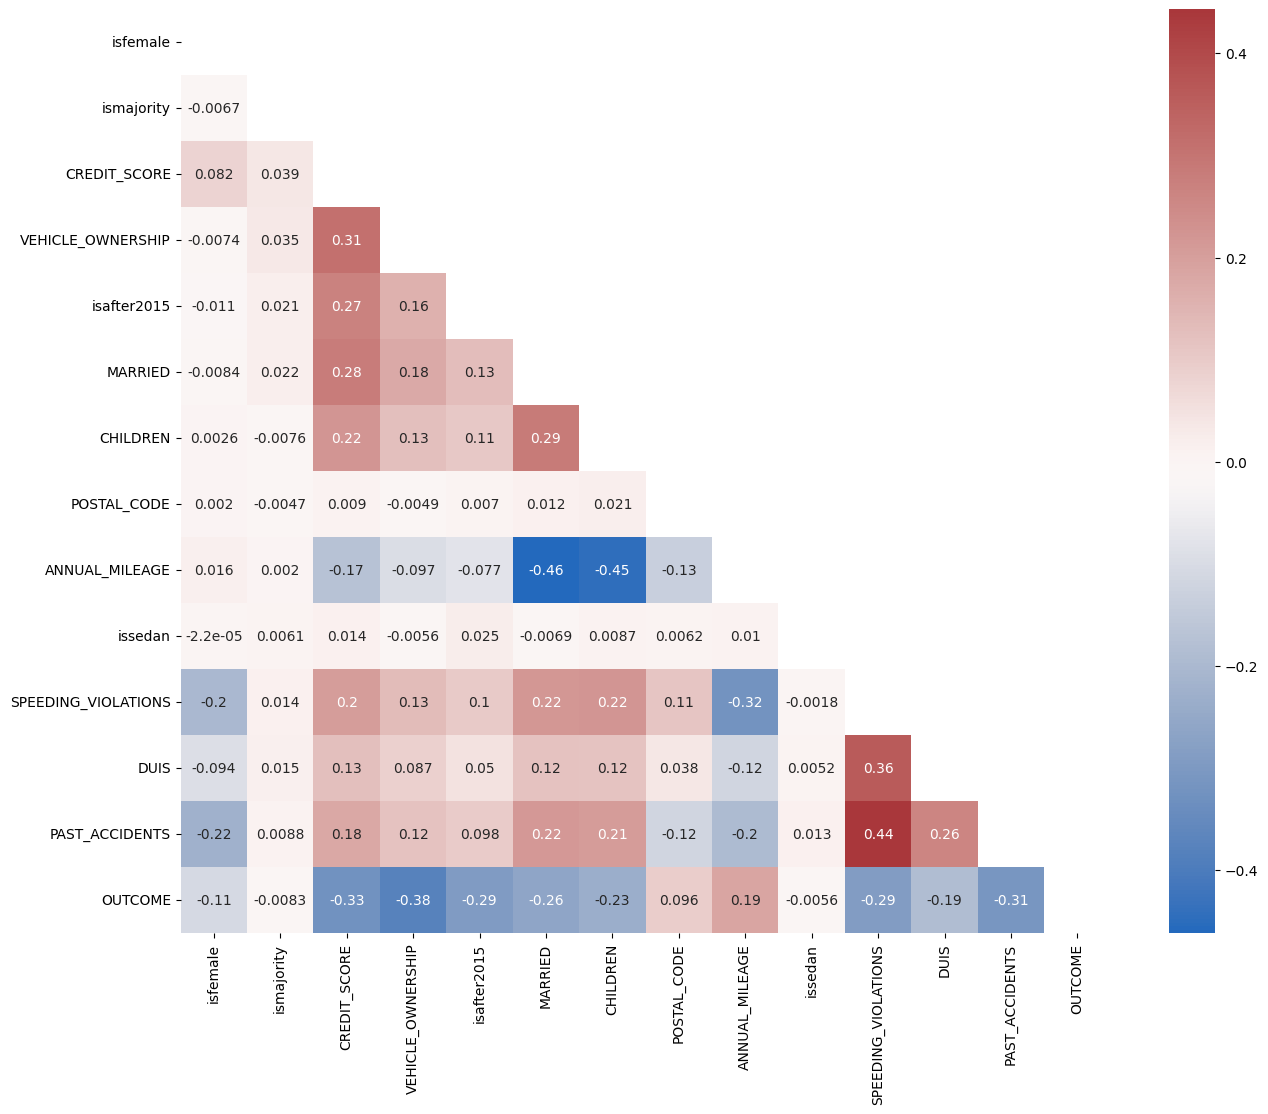

In [129]:
## Define a MatplotLib ax object using sns.heatmap()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(corr, cmap= 'vlag', annot = True, mask = mask);



*   The correlation does not take into account the constant values
*   There is a high negative correlation between married at and annual mileage (-0.46)

###### **Explore Univariate Numerical Function**

##### **Multivariate Functions**

###### **Explore Multivariate Categorical Function**

In [132]:
def plot_categorical_vs_target(df, x, y='OUTCOME',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax

###### **Explore Multivariate Numerical Function**

In [133]:
def plot_numeric_vs_target(df, x, y='OUTCOME',
                           figsize=(6,4)):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

##feature inspection

## Inspecting Each Feature

#### **Categorical Features**

###### **'EDUCATION'**




In [134]:
## Define a variable to identify the feature
## Display the features datatype
feature =  'EDUCATION'
df[feature].dtype

dtype('O')

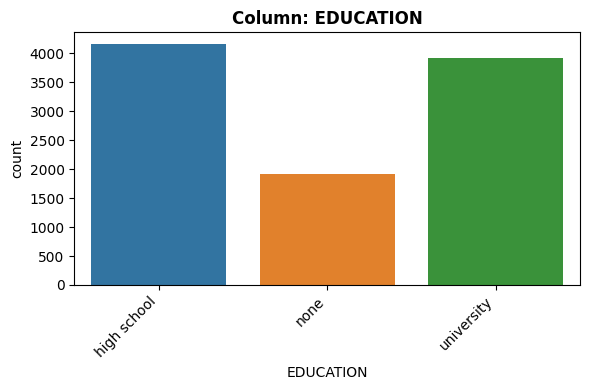

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'high school' occurs 4157 times (41.57%)
- Not constant or quasi-constant.


In [135]:
# Call Univariate Categorical EDA function
explore_categorical(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical (ORDINAL).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no missing values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - No there only (03) unique values (need to be more than 10)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No, there is not

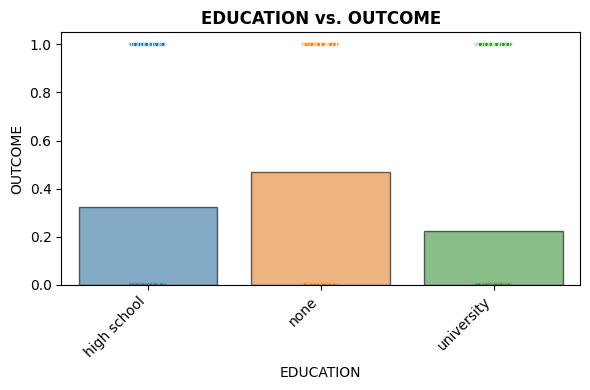

In [136]:
## Call Multivariate Categorical EDA function

plot_categorical_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this feature is  a direct predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This feature does seem to be a predictor of the target.

###### **'AGE' **




In [137]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'AGE'
df[feature].dtype

dtype('O')

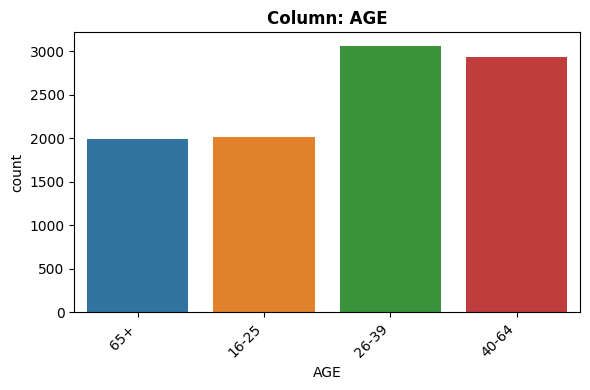

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '26-39' occurs 3063 times (30.63%)
- Not constant or quasi-constant.


In [138]:
# Call Univariate Categorical EDA function
explore_categorical(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical (ordinal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no missing values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - No there only (4) unique values
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No, there is not

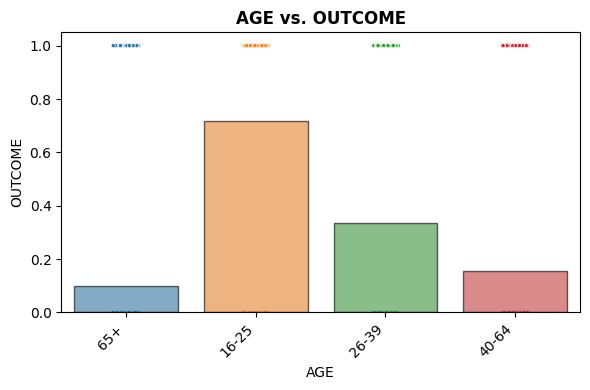

In [139]:
## Call Multivariate Categorical EDA function

plot_categorical_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

 1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this feature is  a direct predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This feature does seem to be a predictor of the target.

###### **'DRIVING_EXPERIENCE'**




In [144]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'DRIVING_EXPERIENCE'
df[feature].dtype

dtype('O')

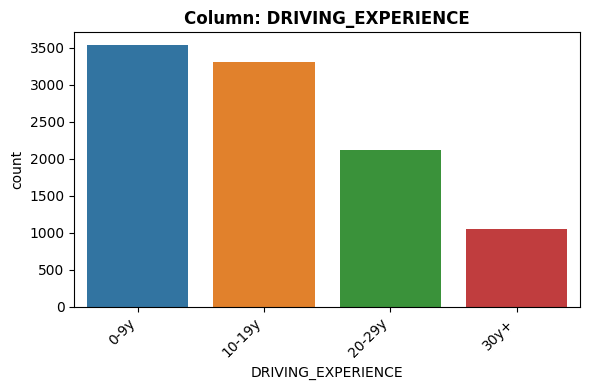

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '0-9y' occurs 3530 times (35.3%)
- Not constant or quasi-constant.


In [145]:
# Call Univariate Categorical EDA function
explore_categorical(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical (ordinal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no missing values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - no there (04) unique values
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No, there is not

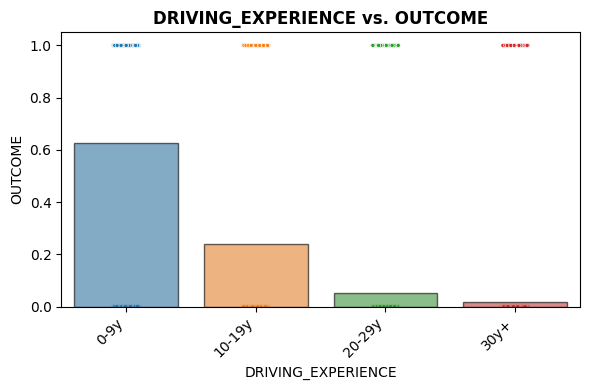

In [146]:
## Call Multivariate Categorical EDA function

plot_categorical_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this feature is  a direct predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This feature does seem to be a predictor of the target.

###### **'EDUCATION'**




In [147]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'EDUCATION'
df[feature].dtype

dtype('O')

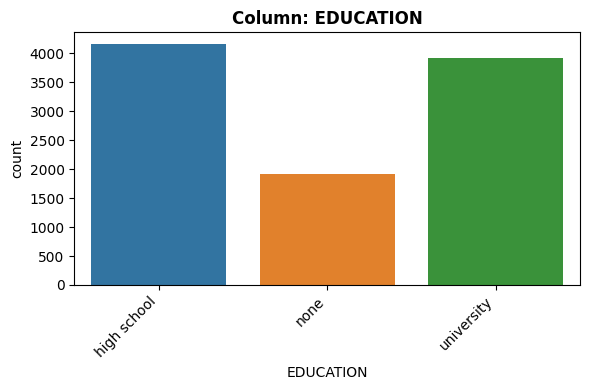

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'high school' occurs 4157 times (41.57%)
- Not constant or quasi-constant.


In [148]:
# Call Univariate Categorical EDA function
explore_categorical(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical (ordinal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - no missing values
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - No there only (3) unique values
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - no

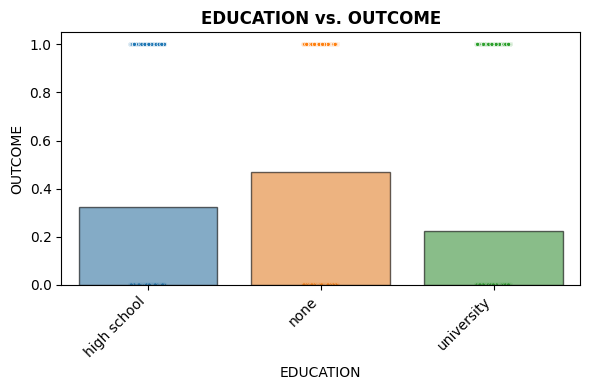

In [149]:
## Call Multivariate Categorical EDA function

plot_categorical_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this feature is  a direct predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This feature does seem to be a predictor of the target.

###### **'INCOME'**




In [150]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'INCOME'
df[feature].dtype

dtype('O')

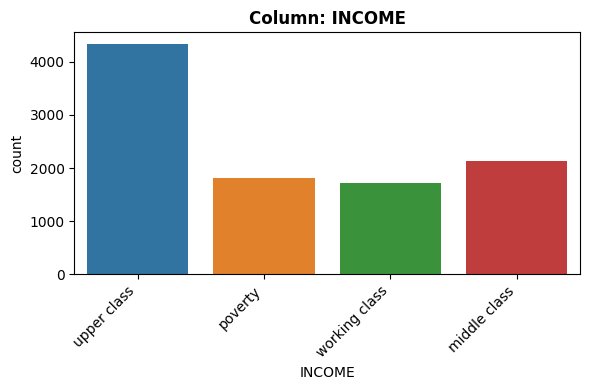

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'upper class' occurs 4336 times (43.36%)
- Not constant or quasi-constant.


In [151]:
# Call Univariate Categorical EDA function
explore_categorical(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical (ordinal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no missing values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - no there (04) unique values
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No, there is not

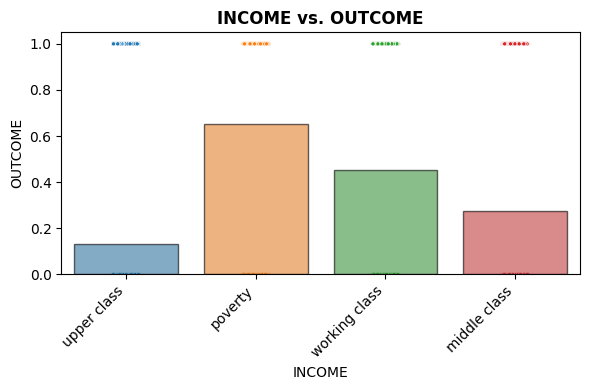

In [152]:
## Call Multivariate Categorical EDA function

plot_categorical_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this feature is  a direct predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This feature does seem to be a predictor of the target.

###### **'POSTAL_CODE'**




In [154]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'POSTAL_CODE'
df[feature].dtype

dtype('int64')

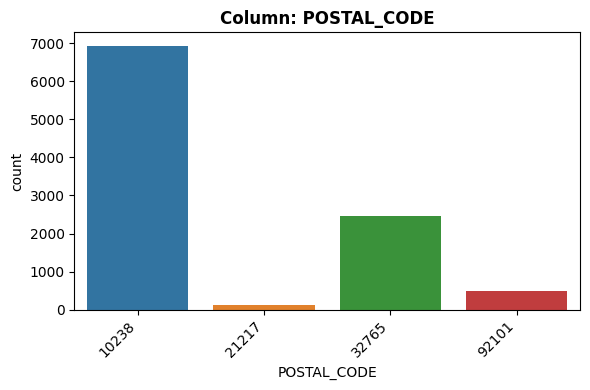

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '10238' occurs 6940 times (69.4%)
- Not constant or quasi-constant.


In [155]:
# Call Univariate Categorical EDA function
explore_categorical(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical (nominal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no missing values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - No there (04) unique values
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No, there is not

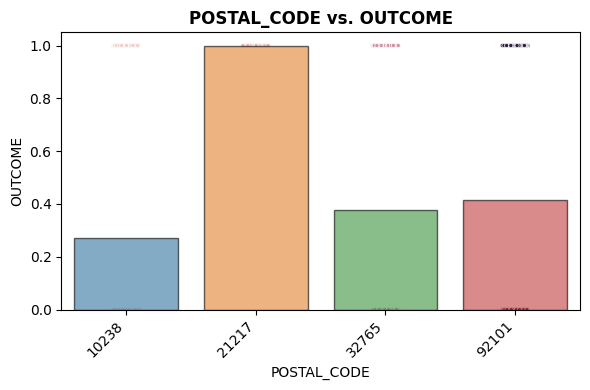

In [156]:
## Call Multivariate Categorical EDA function

plot_categorical_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this feature is  a direct predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This feature does seem to be a predictor of the target.

#### **Numerical Features**

###### **'isfemale'**




In [157]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'isfemale'
df[feature].dtype

dtype('int64')

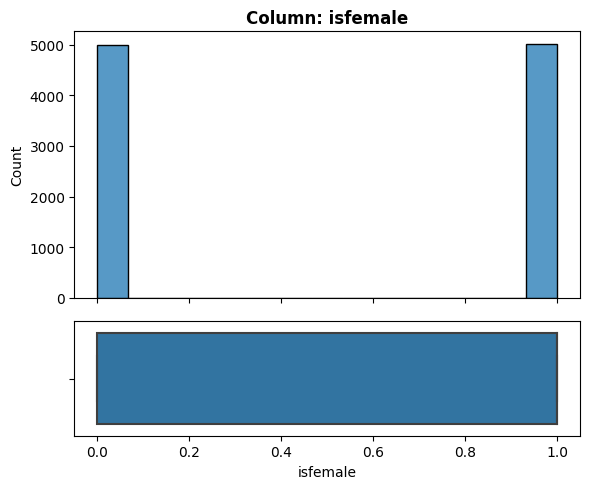

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1' occurs 5010 times (50.1%)
- Not constant or quasi-constant.


In [159]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0  null values

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - yes missing value.

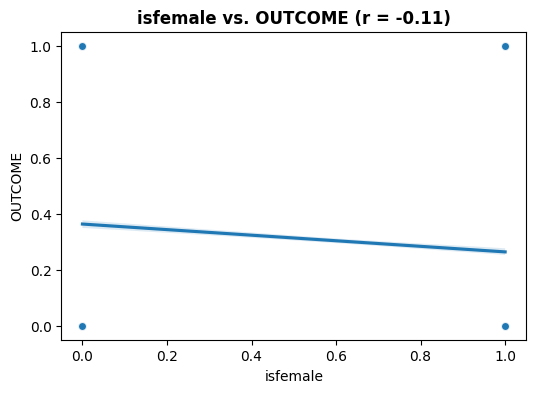

In [160]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target**

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes

2. Does this feature appear to be a predictor of the target?
  - yes, there is a negative correlation (r = -0.11) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target

###### **'ismajority'**




In [161]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'ismajority'
df[feature].dtype

dtype('int64')

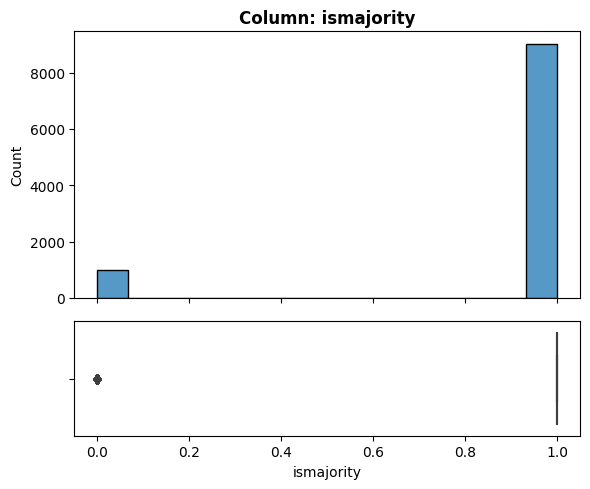

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1' occurs 9012 times (90.12%)
- Not constant or quasi-constant.


In [162]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

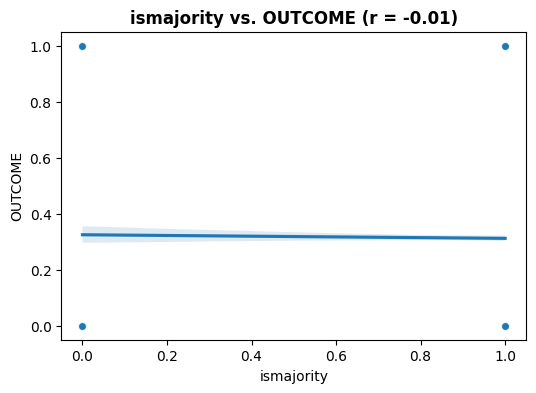

In [163]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes

2. Does this feature appear to be a predictor of the target?
  - no, there is a weak negatif correlation (r = -0.01) between the feature and the target.

###### **'VEHICLE_OWNERSHIP'**




In [164]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'VEHICLE_OWNERSHIP'
df[feature].dtype

dtype('float64')

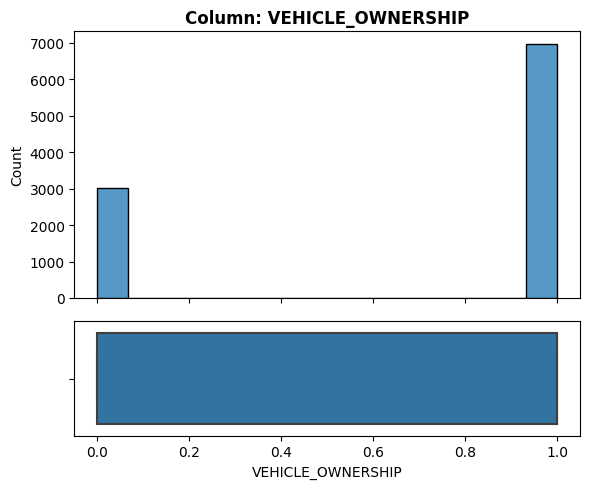

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1.0' occurs 6970 times (69.7%)
- Not constant or quasi-constant.


In [165]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

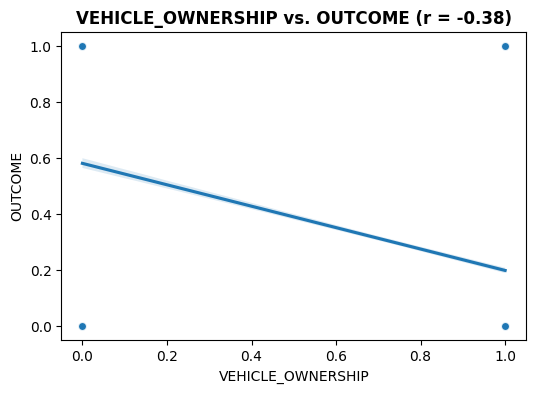

In [166]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - Yes, there is a negative correlation (r = -0.38) between the feature and the target.



###### **'PAST_ACCIDENTS'**




In [167]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'PAST_ACCIDENTS'
df[feature].dtype

dtype('int64')

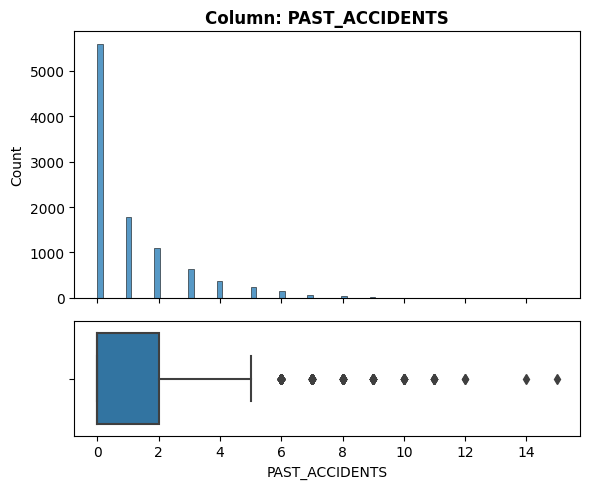

- NaN's Found: 0 (0.0%)
- Unique Values: 15
- Most common value: '0' occurs 5584 times (55.84%)
- Not constant or quasi-constant.


In [168]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

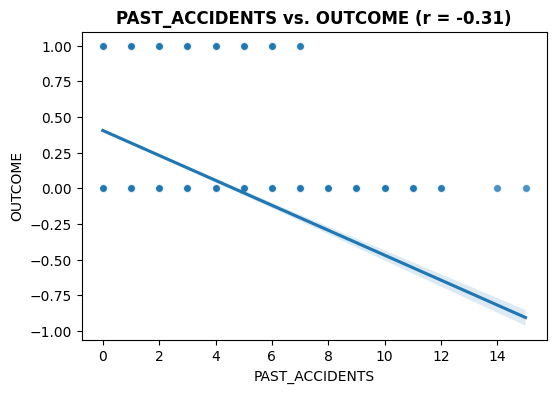

In [169]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - yes, there have the negative correlation (r =- 0.31) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target



###### **'DUIS'**




In [170]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'DUIS'
df[feature].dtype

dtype('int64')

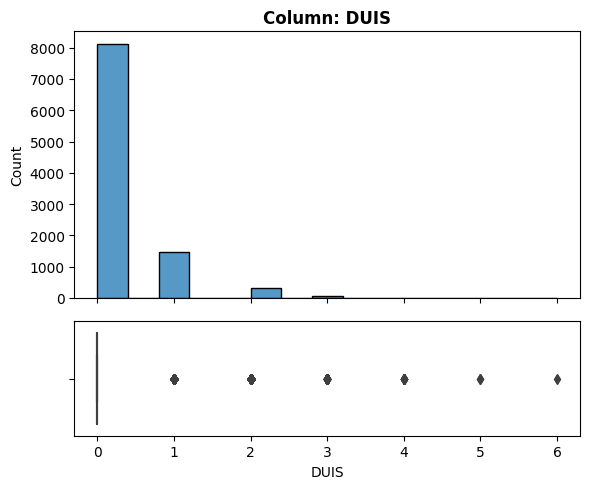

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: '0' occurs 8118 times (81.18%)
- Not constant or quasi-constant.


In [171]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

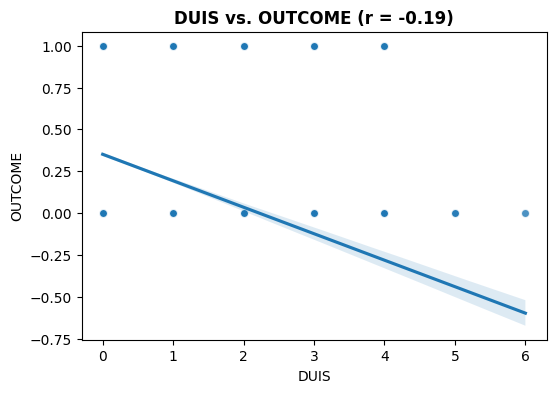

In [172]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - yes, there have the negative correlation (r = - 0.19) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target



###### **'SPEEDING_VIOLATIONS'**




In [173]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'SPEEDING_VIOLATIONS'
df[feature].dtype

dtype('int64')

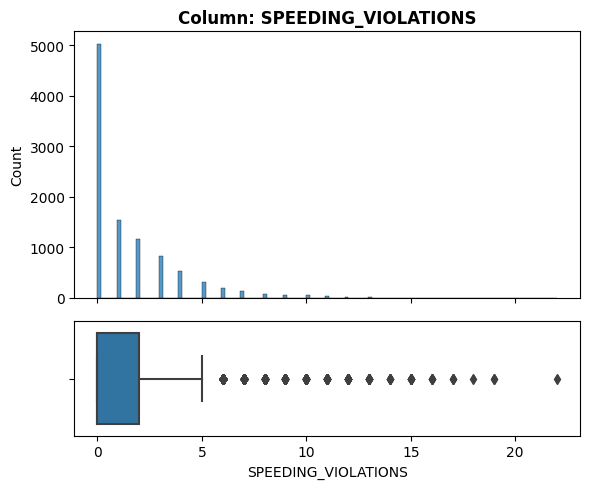

- NaN's Found: 0 (0.0%)
- Unique Values: 21
- Most common value: '0' occurs 5028 times (50.28%)
- Not constant or quasi-constant.


In [174]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

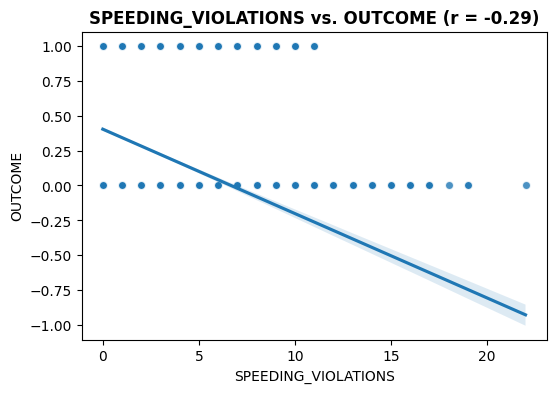

In [175]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - yes, there have the negative correlation (r =- 0.29) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target



###### **'CREDIT_SCORE'**




In [176]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'CREDIT_SCORE'
df[feature].dtype

dtype('float64')

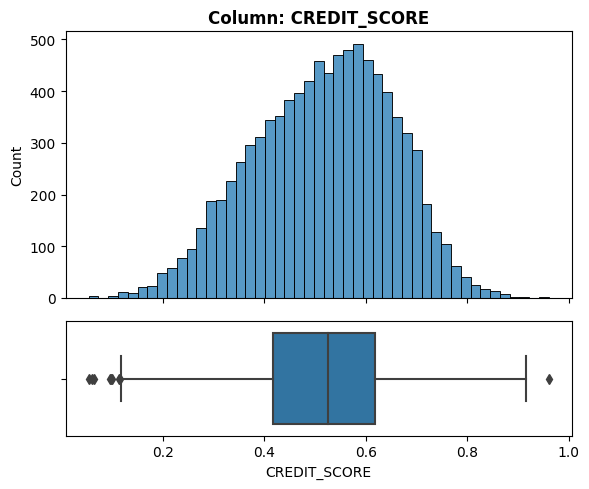

- NaN's Found: 982 (9.82%)
- Unique Values: 9018
- Most common value: 'nan' occurs 982 times (9.82%)
- Not constant or quasi-constant.


In [177]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 982 null values, or 9.82% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - yes values ( but no a lot ).

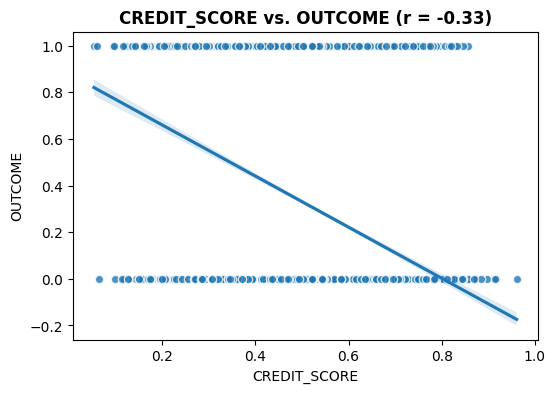

In [178]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - yes, there have the negative correlation (r =- 0.33) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target



###### **'isafter2015'**




In [179]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'isafter2015'
df[feature].dtype

dtype('int64')

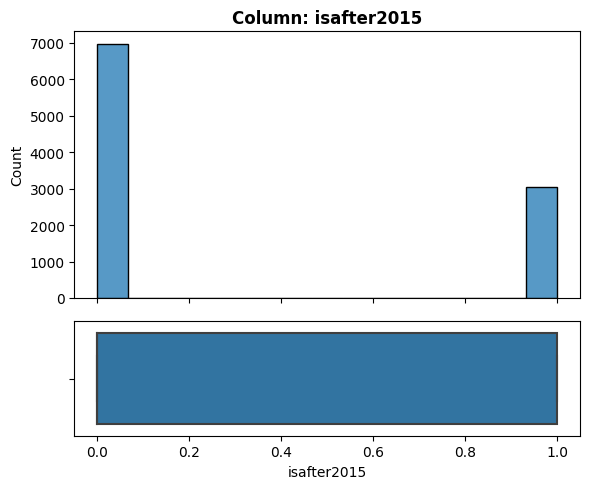

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 6967 times (69.67%)
- Not constant or quasi-constant.


In [180]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

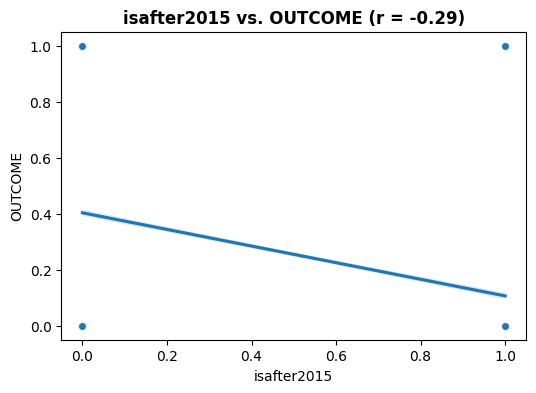

In [181]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - yes, there have the negative correlation (r =- 0.29) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target



###### **'ANNUAL_MILEAGE'**




In [182]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'ANNUAL_MILEAGE'
df[feature].dtype

dtype('float64')

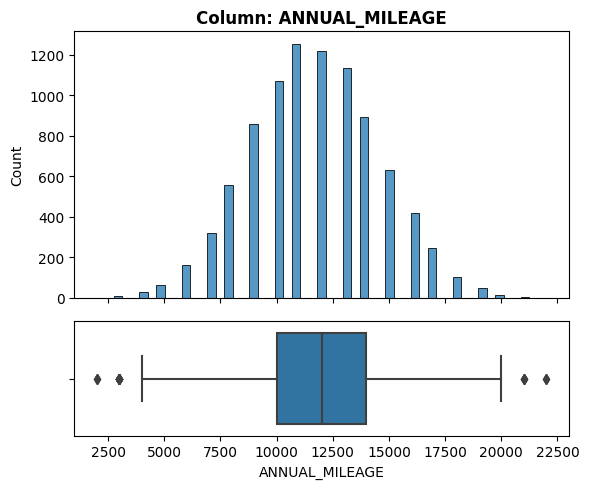

- NaN's Found: 957 (9.57%)
- Unique Values: 21
- Most common value: '11000.0' occurs 1253 times (12.53%)
- Not constant or quasi-constant.


In [183]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 957 null values, or 9.57% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - yes, missing values.

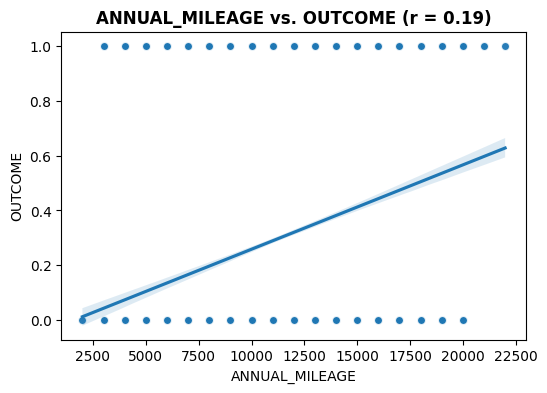

In [184]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - yes, there have the positive correlation (r = 0.19) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target

###### **'MARRIED'**




In [185]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'MARRIED'
df[feature].dtype

dtype('float64')

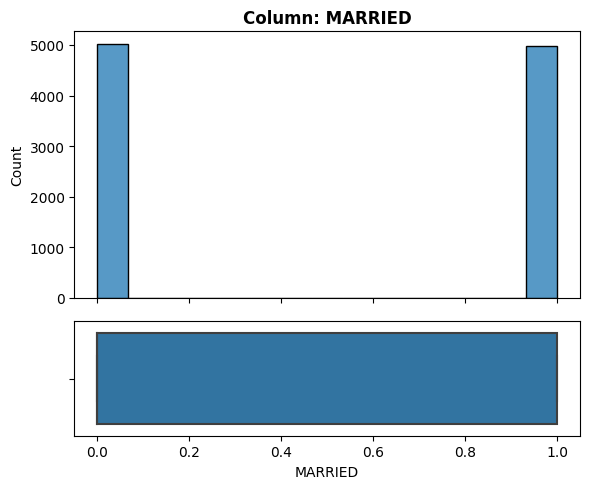

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0.0' occurs 5018 times (50.18%)
- Not constant or quasi-constant.


In [186]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

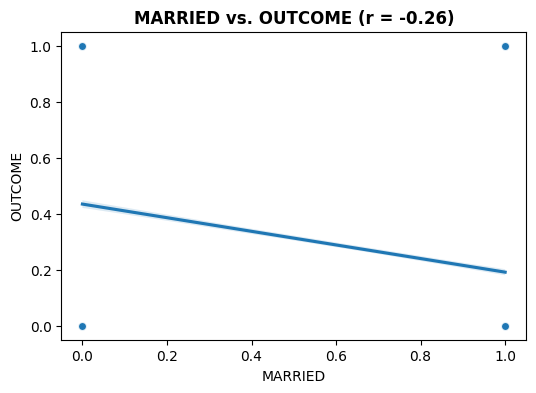

In [187]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - yes, there have the negative correlation (r = - 0.26) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target



###### **'CHILDREN'**




In [188]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'CHILDREN'
df[feature].dtype

dtype('float64')

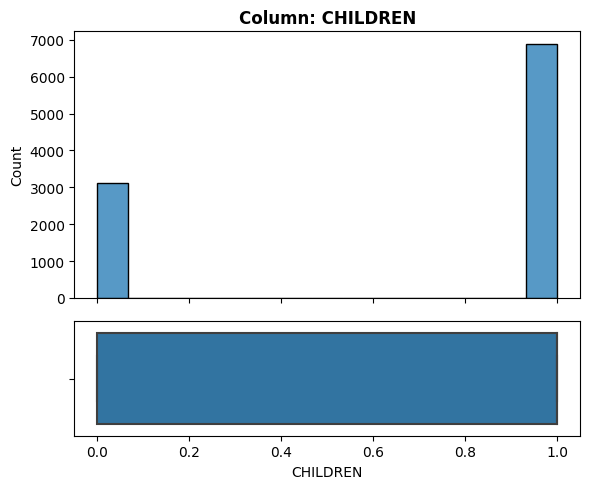

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1.0' occurs 6888 times (68.88%)
- Not constant or quasi-constant.


In [189]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

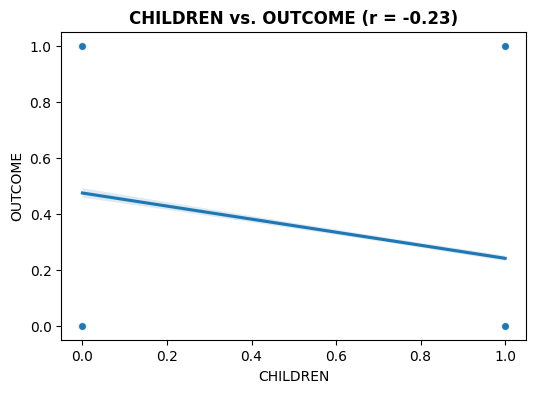

In [190]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - yes, there have the negative correlation (r =- 0.23) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target



###### **'issedan'**




In [191]:
## Define a variable to identify the feature
## Display the features datatype
feature = 'issedan'
df[feature].dtype

dtype('int64')

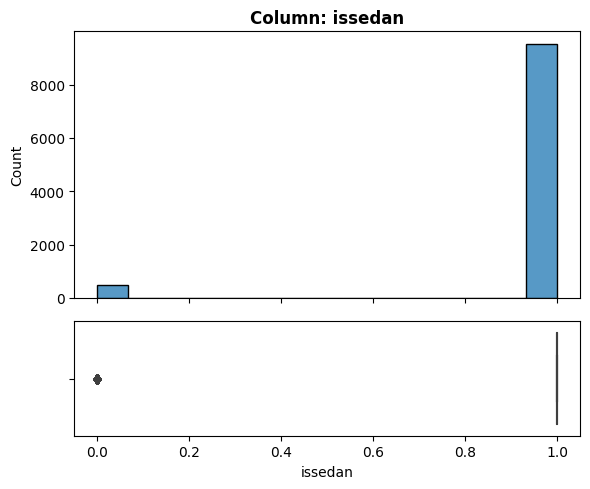

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1' occurs 9523 times (95.23%)
- Not constant or quasi-constant.


In [192]:
## Call Univariate Numerical EDA function
explore_numeric(df, feature);

**Feature Observations**
1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values, or 0% of values.

3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.

4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)

5. Would we know this feature before the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

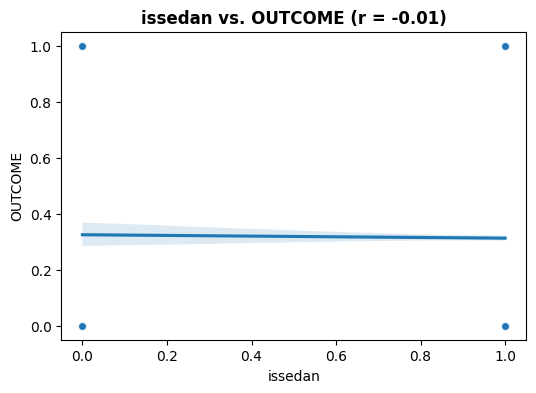

In [193]:
## Call Multivariate Numerical EDA function
plot_numeric_vs_target(df, feature);

- **Feature vs. target( Sales of the product in the particular store Observations)**:

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes.

2. Does this feature appear to be a predictor of the target?
  - vo , there have the  weak negative correlation (r = - 0.01) between the feature and the target.it's important to conduct further analysis and evaluate other factors before concluding whether the feature is a predictor of the target

#### Histograms to view the distributions of numerical features in your dataset

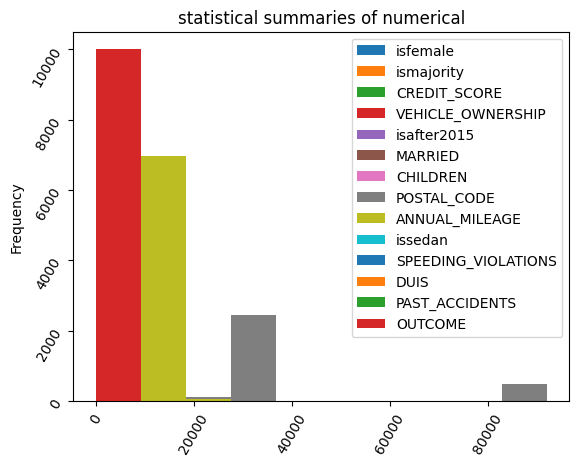

In [195]:
# Histograms to view the distributions of numerical features in your dataset
ax = df[num_cols].plot(kind= 'hist')
 ## Rotate the tick values
ax.tick_params(rotation = 60)

## Set the Title
ax.set_title('statistical summaries of numerical');